In [1]:
%load_ext autoreload
%autoreload 2
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:96% !important; }</style>"))

import os
import torch
import matplotlib.pyplot as plt
from skimage.io import imread
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from skimage import img_as_ubyte
import imageio
import json
import cv2
import time
from PIL import Image
from pytorch3d.loss import (
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)
from torch.optim.lr_scheduler import ReduceLROnPlateau

import torch.nn.functional as F

from tqdm import tqdm_notebook
# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, load_obj
import math
# Data structures and functions for rendering
from pytorch3d.structures import Meshes, Textures, join_meshes_as_batch
from pytorch3d.renderer import (
    look_at_view_transform,
    OpenGLPerspectiveCameras, 
    SfMPerspectiveCameras,
    PointLights, 
    BlendParams,
    DirectionalLights,
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    SoftPhongShader,
    MeshRasterizer,  
    HardPhongShader,
    TexturedSoftPhongShader,
    SoftSilhouetteShader,
    look_at_rotation,
    HardFlatShader
)

# add path for demo utils functions 
import sys
import os
import glob
sys.path.append(os.path.abspath(''))
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from datetime import datetime
def now_str():
    now = datetime.now()
    month = str(now.month)
    day = str(now.day)
    hour = str(now.hour)
    minute = str(now.minute)
    sec = str(now.second)
    
    output = '[{:>02}/{:>02} {:>02}:{:>02}:{:>02}]'.format(month, day, hour, minute, sec)
    return output
def __output_log(path, strs):
    if not os.path.exists(path):
        with open(path, 'w+') as f:
            f.write(strs)
            f.close()
    else:
        with open(path, 'a+') as f:
            f.write(strs)
            f.close()
def get_path(func):  
    if type(func).__name__ == 'function' : 
        return func.__code__.co_filename
    else: 
        raise ValueError("'func' must be a function") 
print(now_str())
print(torch.__version__)
print(torch.version.cuda)
print(get_path(load_obj))

[05/02 19:48:15]
1.4.0
9.2
d:\1_projects\200323_pytorch3dstart\pytorch3d\io\obj_io.py


In [2]:
print('torch.cuda.is_available():',torch.cuda.is_available())

device = torch.device("cuda:0")
torch.cuda.set_device(device)
print('----- torch.cuda.empty_cache() -----')

torch.cuda.empty_cache()
bytes_reserved = torch.cuda.memory_reserved()
print('torch.cuda.memory_reserved(): {:,.2f} Mb'.format(bytes_reserved * 0.000001))
bytes_alloc = torch.cuda.memory_allocated()
print('torch.cuda.memory_allocated(): {:,.2f} Mb'.format(bytes_alloc * 0.000001))
bytes_cached = torch.cuda.memory_cached()
print('torch.cuda.memory_cached(): {:,.2f} Mb'.format(bytes_cached * 0.000001))

torch.cuda.is_available(): True
----- torch.cuda.empty_cache() -----
torch.cuda.memory_reserved(): 0.00 Mb
torch.cuda.memory_allocated(): 0.00 Mb
torch.cuda.memory_cached(): 0.00 Mb


# settings

In [106]:
p_image_sizes = [256]
p_parameter_types = ['verts_deform']
p_num_cams = [1]
p_batch_size = [1]
p_use_texture = [True]
p_target_offset_dist = [0.25] # -1: random deform
p_blur_radius = [0]
p_faces_per_pixel = [1]
p_texturemap_size = [4]
p_sigma = [1e-4]
p_gamma = [1e-4]
p_learning_rate = [0.0001]
p_use_scheduler = [True]
p_loss_type = ['rgba']
# p_loss_type = ['a']

assert(len(p_batch_size) == len(p_num_cams))
p_params = []
for _, param_type in enumerate(p_parameter_types):
    for _, image_size in enumerate(p_image_sizes):
        for i2, num_cams in enumerate(p_num_cams):
            for _, use_texture in enumerate(p_use_texture):
                for _, texturemap_size in enumerate(p_texturemap_size):
                    for _, loss_type in enumerate(p_loss_type):
                        for _, target_offset in enumerate(p_target_offset_dist):
#                             if target_offset > 0.25:
#                                 lr = 0.01
#                             else:
#                                 lr = 0.005
                            lr = 0.005
                            for _, blur_radius in enumerate(p_blur_radius):
                                for _, faces_per_pixel in enumerate(p_faces_per_pixel):
                                    for _, sigma in enumerate(p_sigma):
                                        for _, gamma in enumerate(p_gamma):
                                            for _, use_scheduler in enumerate(p_use_scheduler):
                                                p_params.append(
                                                    {
                                                     'index': len(p_params),
                                                     'nnParameter_type': param_type,
                                                     'image_size': image_size,
                                                     'num_cams': num_cams,
                                                     'batch_size': p_batch_size[i2],
                                                     'use_texture': use_texture,
                                                     'texturemap_size': texturemap_size,
                                                     'loss_type': loss_type,
                                                     'faces_per_pixel': faces_per_pixel,
                                                     'target_offset': target_offset,
                                                     'blur_radius': blur_radius,
                                                     'sigma': sigma,
                                                     'gamma': gamma,
                                                     'lr': lr,
                                                     'use_scheduler': use_scheduler}
                                                    )
print('{} settings'.format(len(p_params)))
def params2string(idx, n_settings, p):
    str_out = '--- [Setting {}/{}] ----------------------\n'.format(idx + 1, n_settings)
    i = 1
    for k, v in p.items():
        if type(v) == str:
            str_out += '{:>2}. {:17}= {}'.format(i, k, v)
        elif isinstance(v, int):
            str_out += '{:>2}. {:17}= {:d}'.format(i, k, v)
        else:
            str_out += '{:>2}. {:17}= {:.4f}'.format(i, k, v)
        str_out += '\n'
        i += 1
    str_out += '\n'
    return str_out

setting_idx = 0
param_str = params2string(setting_idx, len(p_params), p_params[setting_idx])
print(param_str)

obj_name = 'triangle_test'

def export_params(params, export_dir):
    with open(export_dir + '/parameters.json', 'w+') as f:
        json.dump(params, f, indent=4)
    print('saved to:', export_dir)
          
export_dir = './6b_data/output/{}'.format(obj_name)
if not os.path.exists(export_dir):
    os.mkdir(export_dir)
export_params(p_params, export_dir)

1 settings
--- [Setting 1/1] ----------------------
 1. index            = 0
 2. nnParameter_type = verts_deform
 3. image_size       = 256
 4. num_cams         = 1
 5. batch_size       = 1
 6. use_texture      = 1
 7. texturemap_size  = 4
 8. loss_type        = rgba
 9. faces_per_pixel  = 1
10. target_offset    = 0.2500
11. blur_radius      = 0
12. sigma            = 0.0001
13. gamma            = 0.0001
14. lr               = 0.0050
15. use_scheduler    = 1


saved to: ./6b_data/output/triangle_test


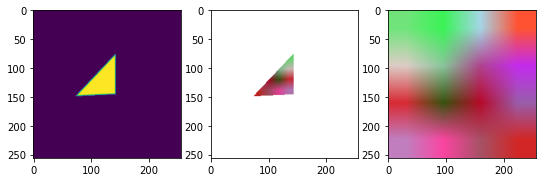

In [107]:
def gen_mesh(mesh_path, device, s, deform=False):
    verts, faces, aux = load_obj(mesh_path)
    use_texturemap = s['use_texture']
    target_offset = s['target_offset']
    np.random.seed(112*len(verts))
    
    faces_idx = faces.verts_idx
    if use_texturemap:
        texturemap_size = s['texturemap_size']
        texturemap_shape = (texturemap_size, texturemap_size, 1)
        texturemap_np = np.random.rand(texturemap_shape[0], texturemap_shape[1], 3).astype(np.float32)
        # texturemap_np = Image.open('./1_data/cow_mesh' + '/cow_texture.png')
        # texturemap_np = texturemap_np.convert('RGB')
        texturemap_np = np.asarray(texturemap_np).astype(np.float32)
#         texturemap_np = cv2.resize(texturemap_np, (raster_settings.image_size, raster_settings.image_size), interpolation=cv2.INTER_NEAREST)
        texturemap_np = cv2.resize(texturemap_np, (raster_settings.image_size, raster_settings.image_size), interpolation=cv2.INTER_LINEAR)
        texturemap_np = np.expand_dims(texturemap_np, axis=0)
        # texturemap_np /= 255.0
        texture_map_torch = torch.from_numpy(texturemap_np).to(device)
        texture_map = nn.Parameter(texture_map_torch, requires_grad=False)
        verts_uvs = aux.verts_uvs[None, ...].to(device)  # (1, V, 2)
        faces_uvs = faces.textures_idx[None, ...].to(device)  # (1, F, 3)
        verts_rgb = torch.ones_like(verts)[None]  # (1, V, 3)
        
        textures = Textures(maps=texture_map, faces_uvs=faces_uvs, verts_uvs=verts_uvs, verts_rgb=verts_rgb.to(device)).to(device)
    else:
        verts_rgb = torch.ones_like(verts)[None]  # (1, V, 3)
        verts_rgb[:, 0, :] = torch.tensor([1.0, 0.0, 0.0])
        verts_rgb[:, 1, :] = torch.tensor([1.0, 0.0, 0.0])
        verts_rgb[:, 2, :] = torch.tensor([1.0, 0.0, 0.0])
#         verts_rgb[:, 1, :] = torch.tensor([0.0, 1.0, 0.0])
#         verts_rgb[:, 2, :] = torch.tensor([0.0, 0.0, 1.0])
        if verts_rgb.shape[1] > 3:
#             verts_rgb[:, 3, :] = torch.tensor([1.0, 1.0, 0.0])
            verts_rgb[:, 3, :] = torch.tensor([1.0, 0.0, 0.0])

        textures = Textures(verts_rgb=verts_rgb.to(device)).to(device)

    # Create a Meshes object for the teapot. Here we have only one mesh in the batch.
    mesh = Meshes(
        verts=[verts.to(device)],   
        faces=[faces_idx.to(device)], 
        textures=textures
    )

    # deform mesh
    if deform:
        verts = mesh.verts_packed().detach().cpu().numpy()
        if target_offset < 0:
            dverts_target = (np.random.rand(verts.shape[0], 3).astype(np.float32) - 0.5)
        else:
            dverts_target = np.zeros((verts.shape[0], 3)).astype(np.float32)
            dverts_target = dverts_target.astype(np.float32)
            dverts_target = dverts_target + np.array([target_offset, target_offset, 0.0]).astype(np.float32)
        dverts_target = torch.from_numpy(dverts_target).to(device)
        mesh = mesh.offset_verts(dverts_target)
    return mesh

distance = 3   # distance from camera to the object
elevation = 0.0   # angle of elevation in degrees
azimuth = 150.0  # No rotation so the camera is positioned on the +Z axis. 
R, T = look_at_view_transform(distance, elevation, azimuth, device=device)
cameras = OpenGLPerspectiveCameras(device=device, R=R, T=T)
blend_params = BlendParams(sigma=1e-4, gamma=1e-4)
raster_settings = RasterizationSettings(
    image_size=p_image_sizes[0], 
    blur_radius=0.0, #np.log(1. / 1e-4 - 1.) * blend_params.sigma, 
    faces_per_pixel=1, 
)
lights = PointLights(device=device, location=((2.0, 2.0, -2.0),))
a_diffuse = 0.0
a_ambient = 0.9
s = torch.from_numpy(np.zeros((1, 3)).astype(np.float32)).to(device)
d = torch.from_numpy(np.ones((1, 3)).astype(np.float32)*a_diffuse).to(device)
a = torch.from_numpy(np.ones((1, 3)).astype(np.float32)*a_ambient).to(device)
lights.specular_color = s
lights.diffuse_color = d
lights.ambient_color = a


in_dir = './2_data'
mesh_path = in_dir + '/{}.obj'.format('triangle')
param_idx = len(p_params)-1
param_idx = 0
mesh_target = gen_mesh(mesh_path, device, p_params[param_idx], deform=True)

if p_params[param_idx]['use_texture']:
    sample_renderer = MeshRenderer(
        rasterizer=MeshRasterizer(cameras=cameras,raster_settings=raster_settings),
        shader=TexturedSoftPhongShader(device=device, blend_params=blend_params, lights=lights)
    )
else:
    sample_renderer = MeshRenderer(
        rasterizer=MeshRasterizer(cameras=cameras,raster_settings=raster_settings),
        shader=SoftPhongShader(device=device, lights=lights, blend_params=blend_params)
    )
    
image_rendered = sample_renderer(meshes_world=mesh_target).detach().cpu().numpy().squeeze()
silhouette = image_rendered[..., 3]
image_rendered = image_rendered[..., :3]

fig, ax = plt.subplots(1, 3, figsize=(9, 3))
ax[0].imshow(silhouette)
ax[1].imshow(image_rendered)
if mesh_target.textures._maps_padded is not None:
    mesh_texturemaps = mesh_target.textures._maps_padded.detach().squeeze().cpu().numpy()
    ax[2].imshow(mesh_texturemaps, vmin=0, vmax=255)
else:
    ax[2].axis('off')
plt.show()


1/1


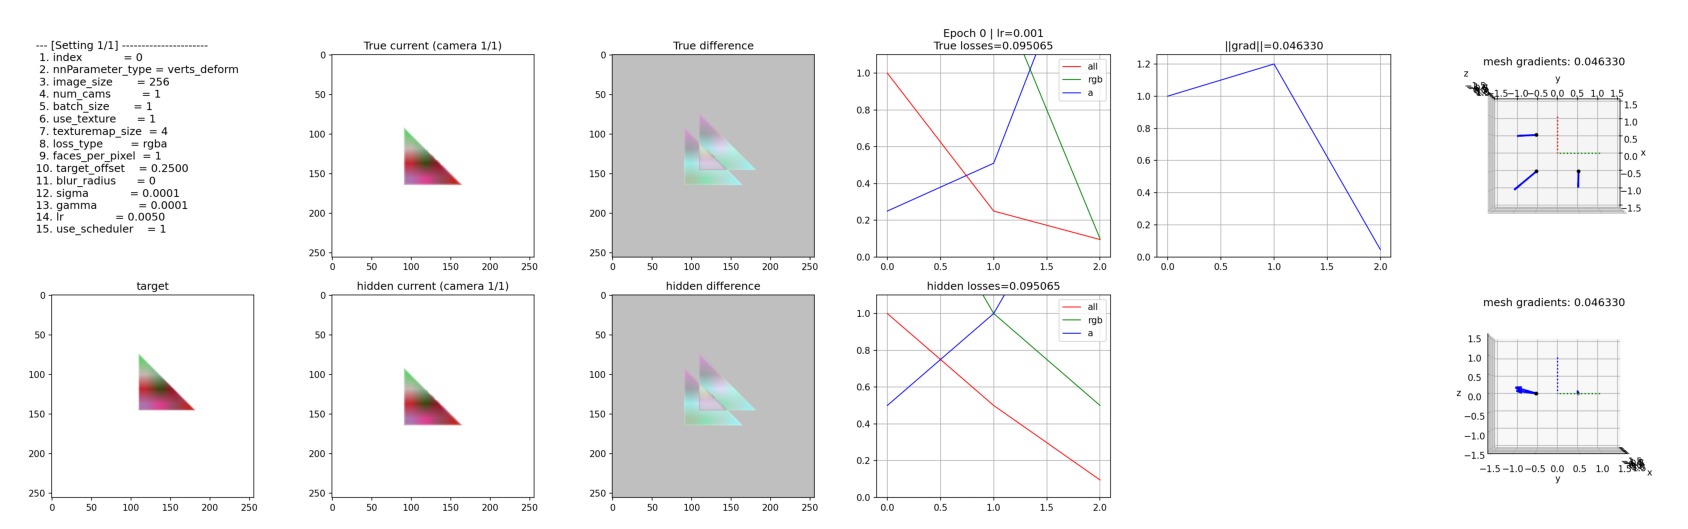

In [108]:
class Model(nn.Module):
    def __init__(self, device, **kwargs):
        super().__init__()
        
        self.device = device
        self.n_cams = kwargs.get('n_cams', None)
        self.cameras = None
        self.nnParameter_type = kwargs.get('nnParameter_type', None)
        self.image_size = kwargs.get('image_size', None)
        self.mesh = kwargs.get('mesh', None)
        self.mesh_target = kwargs.get('mesh_target', None)
        
        self.blend_params_for_loss = BlendParams(sigma=1e-4, gamma=1e-4)
        self.raster_settings_for_loss = RasterizationSettings(
            image_size=self.image_size, 
            blur_radius=0,
            faces_per_pixel=1, 
        )
        
        self.use_texture = kwargs.get('use_texture', None)
        self.loss_type = kwargs.get('loss_type', None)
        self.batch_size = kwargs.get('batch_size', None)
        self.n_batch = int(self.n_cams / self.batch_size)
        self.camera_batches = self._init_cameras()
        
        self.renderer = self._init_renderer()
        self.target_image_batches = self._init_target_images()
        
        if self.nnParameter_type == 'translate':
            self.center_offset = torch.from_numpy(np.zeros((3), dtype=np.float32)).to(self.device)
            self.center_offset = nn.Parameter(self.center_offset, requires_grad=True)
            self.dverts = None
        elif self.nnParameter_type == 'verts_deform':
            self.dverts = torch.from_numpy(np.zeros((self.mesh.verts_packed().shape), dtype=np.float32)).to(self.device)
            self.dverts = nn.Parameter(self.dverts, requires_grad=True)
            self.center_offset = None
        
    def forward(self, batch_idx, raster_settings, blend_params):
        target_images = self.target_image_batches[batch_idx]

        # ==================================================================================== #
        # minibatch training
        i0 = batch_idx*self.batch_size
        i1 = i0 + self.batch_size
        
        # batch preparation
        if self.nnParameter_type == 'translate':
            dverts = []
            for _ in range(self.mesh.verts_packed().shape[0]):
                dverts.append(self.center_offset)
            dverts = torch.stack(dverts)
        elif self.nnParameter_type == 'verts_deform':
            dverts = self.dverts
        mesh_deformed = self.mesh.offset_verts(dverts)
        meshes = mesh_deformed.extend(self.batch_size)
        cam_batch = self.camera_batches[batch_idx]
        
        # render
        images = self.renderer(meshes_world=meshes, cameras=cam_batch, raster_settings=raster_settings, blend_params=blend_params)
        images_true = self.renderer(meshes_world=meshes, cameras=cam_batch, raster_settings=self.raster_settings_for_loss, blend_params=self.blend_params_for_loss)
        images_true = images_true.detach()
        
        # losses
        if self.loss_type == 'a':
            # loss for gradient
            loss_silhouette = torch.mean(torch.abs(images[..., 3] - target_images[..., 3]))
            loss_pixel = None
            loss = loss_silhouette
            # true loss
            loss_silhouette_true = torch.mean(torch.abs(images_true[..., 3] - target_images[..., 3]))
            loss_true = loss_silhouette_true
            loss_pixel_true = None
        elif self.loss_type == 'rgb':
            # loss for gradient
            loss_silhouette = None
            loss_pixel = torch.mean(torch.abs(images[..., :3] - target_images[..., :3]))
            loss = loss_pixel
            # true loss
            loss_silhouette_true = None
            loss_pixel_true = torch.mean(torch.abs(images_true[..., :3] - target_images[..., :3]))
            loss_true = loss_pixel_true
        elif self.loss_type == 'rgba':
            # loss for gradient
            loss_pixel = torch.mean(torch.abs(images[..., :3] - target_images[..., :3]))
            loss_silhouette = torch.mean(torch.abs(images[..., 3] - target_images[..., 3]))
            loss = loss_pixel + loss_silhouette
            # true loss
            loss_pixel_true = torch.mean(torch.abs(images_true[..., :3] - target_images[..., :3]))
            loss_silhouette_true = torch.mean(torch.abs(images_true[..., 3] - target_images[..., 3]))
            loss_true = loss_pixel_true + loss_silhouette_true
        else:
            assert(False)
        
        loss_dict = {'all': loss, 'pixel': loss_pixel, 'silhouette': loss_silhouette}
        true_loss_dict = {'all': loss_true, 'pixel': loss_pixel_true, 'silhouette': loss_silhouette_true}
        image_dict = {'images': images, 'target_images': target_images}
        image_true_dict = {'images': images_true}
        return image_dict, image_true_dict, loss_dict, true_loss_dict
    
    def _iou(self, S1, S2):
        S1S2 = torch.mul(S1, S2)
        return torch.mean(1.0 - torch.sum(torch.abs(S1S2)) / torch.sum(torch.abs(S1+S2-S1S2)))
    
    def _init_target_images(self):
        meshes = self.mesh_target.extend(self.batch_size)
        
        target_image_batches = []
        for batch_idx in range(self.n_batch):
            cam_batch = self.camera_batches[batch_idx]
            target_images = self.renderer(meshes_world=meshes, cameras=cam_batch, raster_settings=self.raster_settings_for_loss, blend_params=self.blend_params_for_loss)
            target_image_batches.append(target_images)
            
        return target_image_batches
        
    def _init_cameras(self):
        d_angle = 360.0 / self.n_cams
        camera_batches = []
        for batch_idx in range(self.n_batch):
            i0 = batch_idx*self.batch_size
            i1 = i0 + self.batch_size
            
            R_batch = torch.empty([batch_size, 3, 3])
            T_batch = torch.empty([batch_size, 3])
            for i in range(self.batch_size):
                distance = 3
                elevation = 0.0
                azimuth = d_angle * (i0 + i)
                Ri, Ti = look_at_view_transform(distance, elevation, azimuth, device=self.device)
                R_batch[i] = Ri.squeeze()
                T_batch[i] = Ti.squeeze()
            cam_batch = OpenGLPerspectiveCameras(device=self.device, R=R_batch, T=T_batch)
            camera_batches.append(cam_batch)
        return camera_batches
            
    def _init_renderer(self):
        blend_params = BlendParams(sigma=1e-4, gamma=1e-4)
        raster_settings = RasterizationSettings(
            image_size=self.image_size, 
            blur_radius=0, #np.log(1. / 1e-4 - 1.) * blend_params.sigma, 
            faces_per_pixel=1, 
        )
        
        
        lights = PointLights(device=self.device, location=((2.0, 2.0, -2.0),)).to(self.device)
        a_diffuse = 0.0
        a_ambient = 0.9
        s = torch.from_numpy(np.zeros((1, 3)).astype(np.float32)).to(self.device)
        d = torch.from_numpy(np.ones((1, 3)).astype(np.float32)*a_diffuse).to(self.device)
        a = torch.from_numpy(np.ones((1, 3)).astype(np.float32)*a_ambient).to(self.device)
        lights.specular_color = s
        lights.diffuse_color = d
        lights.ambient_color = a
        
        rasterizer = MeshRasterizer(cameras=self.cameras, raster_settings=raster_settings)
        
        if self.use_texture:
            shader=TexturedSoftPhongShader(device=self.device, lights=lights, blend_params=blend_params)
        else:
            shader=SoftPhongShader(device=self.device, lights=lights, blend_params=blend_params)
        
        renderer = MeshRenderer(
            rasterizer=rasterizer,
            shader=shader
        )
            
        return renderer

    
def render_plots(return_image, is_cuda, out_dir, e, param_idx, params, cam_idx, model, lr, losses, losses_true, grad_values, grad_norms, image_true, image, image_target):
    loss_type = params[param_idx]['loss_type']
    diff_true = (np.abs(image_target-image_true)+ 1.0) / 2.0
    diff      = (np.abs(image_target-image     )+ 1.0) / 2.0
    
    if is_cuda:
        max_loss = max(max(losses_true['all']), max(losses['all'])).cpu().numpy()
    else:
        max_loss = max(max(losses_true['all']), max(losses['all']))
    
    fig, ax = plt.subplots(2, 6, figsize=(26, 8), tight_layout=True)
    
    a_stat = ax[0, 0]
    a_tloss = ax[0, 3]
    a_tcurr = ax[0, 1]
    a_tdiff = ax[0, 2]
    a_gradnorm = ax[0, 4]
    a_gradvec1 = ax[0, 5]
    a_target = ax[1, 0]
    a_loss = ax[1, 3]
    a_curr = ax[1, 1]
    a_diff = ax[1, 2]
    a_gradvec2 = ax[1, 5]
    a_gradvec3 = ax[1, 4]
    
    a_tloss.plot(losses_true['all'], linewidth=1, c='r')
    a_tloss.set_title('Epoch {} | lr={}\nTrue losses={:.6f}'.format(e, lr, losses_true['all'][-1]))
    if model.loss_type == 'rgba':
        a_tloss.plot(losses_true['pixel'], linewidth=1, c='g')
        a_tloss.plot(losses_true['silhouette'], linewidth=1, c='b')
        a_tloss.legend(['all', 'rgb', 'a'])
    a_tloss.grid()
    a_tloss.set_ylim(bottom=0, top=max_loss*1.1)
    
    
    a_loss.plot(losses['all'], linewidth=1, c='r')
    a_loss.set_title('hidden losses={:.6f}'.format(losses['all'][-1]))
    if model.loss_type == 'rgba':
        a_loss.plot(losses['pixel'], linewidth=1, c='g')
        a_loss.plot(losses['silhouette'], linewidth=1, c='b')
        a_loss.legend(['all', 'rgb', 'a'])
    a_loss.grid()
    a_loss.set_ylim(bottom=0, top=max_loss*1.1)
    
    if loss_type == 'a':
        a_curr.imshow(image, cmap='gray')
        a_diff.imshow(diff, cmap='gray')
        a_tcurr.imshow(image_true, cmap='gray')
        a_tdiff.imshow(diff_true, cmap='gray')
        a_target.imshow(image_target, cmap='gray')
    else:
        a_curr.imshow(image)
        a_diff.imshow(diff)
        a_tcurr.imshow(image_true)
        a_tdiff.imshow(diff_true)
        a_target.imshow(image_target)
        
    a_curr.set_title('hidden current (camera {}/{})'.format(cam_idx+1, model.n_cams))
    a_tcurr.set_title('True current (camera {}/{})'.format(cam_idx+1, model.n_cams))
    a_target.set_title('target')
    
    a_diff.set_title('hidden difference')
    a_tdiff.set_title('True difference')
    
    param_str = params2string(param_idx, len(params), params[param_idx])
    a_stat.text(0, 0, param_str, fontsize=12)
    a_stat.axis('off')
    
    a_gradnorm.plot(grads, linewidth=1, c='b')
    a_gradnorm.set_title('||grad||={:.6f}'.format(grads[-1]))
    a_gradnorm.grid()
    a_gradnorm.set_ylim(bottom=0)
    
    
    a_gradvec1.axis('off')
    a_gradvec1 = fig.add_subplot(2, 6, 6, projection='3d')
    verts = model.mesh.verts_packed().detach().cpu().numpy()
    mesh_verts = model.mesh.verts_packed().detach().cpu().numpy()
    if model.nnParameter_type == 'translate':
        verts = np.mean(mesh_verts, axis=0)
        
    a_gradvec1.set_title('mesh gradients: {:.6f}'.format(grad_norms[-1]))
    grad_values /= grad_norms[-1]
    if model.nnParameter_type == 'translate':
        a_gradvec1.quiver(verts[0], verts[1], verts[2], grad_values[0], grad_values[1], grad_values[2], normalize=False, lw=2, color='r')
        a_gradvec1.scatter(verts[0], verts[1], verts[2], c='k', s=10)
    elif model.nnParameter_type == 'verts_deform':
        a_gradvec1.quiver(verts[:,0], verts[:,1], verts[:,2], grad_values[:,0], grad_values[:,1], grad_values[:,2], normalize=False, lw=2, color='b')
    a_gradvec1.scatter(mesh_verts[:,0], mesh_verts[:,1], mesh_verts[:,2], c='k', s=10)
    a_gradvec1.view_init(elev=-90, azim=0)
    a_gradvec1.set_xlabel('x'), a_gradvec1.set_ylabel('y'), a_gradvec1.set_zlabel('z')
    a_gradvec1.quiver(np.array([0, 0, 0]), np.array([0, 0, 0]), np.array([0, 0, 0]), np.array([1, 0, 0]), np.array([0, 1, 0]), np.array([0, 0, 1]), color=['r', 'g', 'b'], linestyle=':', normalize=True, arrow_length_ratio=0)
    L = 1.5
    a_gradvec1.set_xlim([-L, L]), a_gradvec1.set_ylim([-L, L]), a_gradvec1.set_zlim([-L, L])
    
    a_gradvec2.axis('off')
    a_gradvec2 = fig.add_subplot(2, 6, 12, projection='3d')
    a_gradvec2.quiver(np.array([0, 0, 0]), np.array([0, 0, 0]), np.array([0, 0, 0]), np.array([1, 0, 0]), np.array([0, 1, 0]), np.array([0, 0, 1]), color=['r', 'g', 'b'], linestyle=':', normalize=True, arrow_length_ratio=0)
    verts = model.mesh.verts_packed().detach().cpu().numpy()
    mesh_verts = model.mesh.verts_packed().detach().cpu().numpy()
    if model.nnParameter_type == 'translate':
        verts = np.mean(mesh_verts, axis=0)
        
    a_gradvec2.set_title('mesh gradients: {:.6f}'.format(grad_norms[-1]))
    if model.nnParameter_type == 'translate':
        a_gradvec2.quiver(verts[0], verts[1], verts[2], grad_values[0], grad_values[1], grad_values[2], normalize=False, lw=2, color='r')
        a_gradvec2.scatter(verts[0], verts[1], verts[2], c='k', s=10)
    elif model.nnParameter_type == 'verts_deform':
        a_gradvec2.quiver(verts[:,0], verts[:,1], verts[:,2], grad_values[:,0], grad_values[:,1], grad_values[:,2], normalize=False, lw=2, color='b')
    a_gradvec2.scatter(mesh_verts[:,0], mesh_verts[:,1], mesh_verts[:,2], c='k', s=10)
    a_gradvec2.view_init(elev=0, azim=0)
    a_gradvec2.set_xlabel('x'), a_gradvec2.set_ylabel('y'), a_gradvec2.set_zlabel('z')
    a_gradvec2.set_xlim([-L, L]), a_gradvec2.set_ylim([-L, L]), a_gradvec2.set_zlim([-L, L])
    
    a_gradvec3.axis('off')
    out_path = out_dir + '/plot_{}.png'.format(e)
    plt.savefig(out_path, dpi=150)
    plt.close('all')
    
    if return_image:
        return imageio.imread(out_path)
    return None
    
torch.cuda.empty_cache()
param_idx = len(p_params)-1
mesh_path = in_dir + './{}.obj'.format('triangle')
out_dir = './6b_data/output/{}'.format(obj_name)
    
for param_idx, p in enumerate(p_params):
    if param_idx < 0:
        continue
    print('{}/{}'.format(param_idx+1, len(p_params)))
    # print(params2string(param_idx, len(p_params), p))
    nnParameter_type = p['nnParameter_type']
    loss_type = p['loss_type']
    batch_size = p['batch_size']
    use_texture = p['use_texture']
    image_size = p['image_size']
    mesh_target = gen_mesh(mesh_path, device, p, deform=True)
    mesh = gen_mesh(mesh_path, device, p, deform=False)
    model = Model(device=device, mesh=mesh, mesh_target=mesh_target, nnParameter_type=nnParameter_type, loss_type=loss_type, n_cams=num_cams, batch_size=batch_size, use_texture=use_texture, image_size=image_size)


    # ================== #
    # test run
    blend_params = BlendParams(sigma=p['sigma'], gamma=p['gamma'])
    raster_settings = RasterizationSettings(
            image_size=image_size, 
            blur_radius=p['blur_radius'],
            faces_per_pixel=p['faces_per_pixel']
    )

    lr = p['lr']
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    losses = {'all': [], 'pixel': [], 'silhouette': []}
    losses_true = {'all': [], 'pixel': [], 'silhouette': []}
    optimizer.zero_grad()
    image_dict, image_true_dict, loss_dict, loss_true_dict = model(batch_idx=0, raster_settings=raster_settings, blend_params=blend_params)
    for k, v in loss_dict.items():
        if v is not None:
            vv = v.detach().cpu().numpy()
            losses[k].append(vv)
            losses_true[k].append(loss_true_dict[k].detach().cpu().numpy())
    loss = loss_dict['all']
    loss.backward()
    optimizer.step()
    # ================== #

    return_image = True
    e = 0
    cam_idx = 0

    losses = {'all': [1, 0.5, loss_dict['all']], 'pixel': [2, 1, 0.5], 'silhouette': [0.5, 1, 2]}
    losses_true = {'all': [1, 0.25, loss_true_dict['all']], 'pixel': [2, 1.5, 0.1], 'silhouette': [0.25, 0.51, 2.0]}
    if model.nnParameter_type == 'translate':
        grad_values = model.center_offset.grad.detach().cpu().numpy()
    elif model.nnParameter_type == 'verts_deform':
        grad_values = model.dverts.grad.detach().cpu().numpy()
    grad_norm = np.linalg.norm(grad_values)
    grads = [1, 1.2, grad_norm]
    image = image_dict['images'][cam_idx].detach().cpu().numpy()
    image_true = image_true_dict['images'][cam_idx].cpu().numpy()
    image_target = image_dict['target_images'][cam_idx].detach().cpu().numpy()

    if model.loss_type == 'a':
        image = image[..., 3]
        image_true = image_true[..., 3]
        image_target = image_target[..., 3]
    else:
        image = image[..., :4]
        image_true = image_true[..., :4]
        image_target = image_target[..., :4]
    
    plot_image = render_plots(return_image, False, out_dir, e, param_idx, p_params, cam_idx, model, 0.001, losses, losses_true, grad_values, grads, image_true, image, image_target)
    plt.figure(figsize=(30, 15))
    plt.imshow(plot_image)
    plt.axis('off')
    plt.show()
    break

outputs: ./6b_data/output/triangle_test
##############################
./2_data/triangle.obj
##############################
Param_idx=0, total count=1 =====================================================================================
Log output: ./6b_data/output/triangle_test/setting_0/log_20200502.txt


<ipython-input-110-052d17fa9a60>:57: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  loop = tqdm_notebook(range(1000000000))


[[-0.02373459 -0.02469842  0.00807217]
 [-0.02065304 -0.00042661  0.00337107]
 [-0.00125212 -0.02137933  0.00335453]]
0.046330266


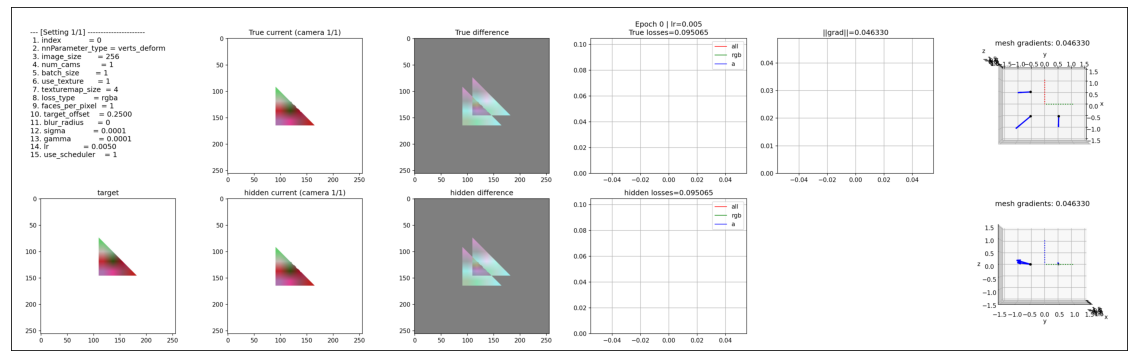

[[ 0.05659619  0.05528929 -0.01843039]
 [ 0.06269944 -0.00077749 -0.01045885]
 [-0.00175436  0.04001522 -0.00688635]]
0.11087219
[[-0.02331041 -0.02382827  0.00780298]
 [-0.02083438 -0.00059399  0.00335121]
 [-0.00179391 -0.02126202  0.00321202]]
0.045643315
[[-0.02359748 -0.02395362  0.00787766]
 [-0.0213074  -0.00102085  0.00336265]
 [-0.00200681 -0.02158377  0.00322467]]
0.04625272
[[-0.02355667  0.04076606 -0.00284259]
 [-0.02123988 -0.00099598  0.00335274]
 [-0.0022237   0.03818809 -0.00668098]]
0.06477766
[[ 0.03407678 -0.01735748 -0.00274704]
 [-0.00310623 -0.00129348  0.00028843]
 [-0.00198594  0.00734912 -0.00156093]]
0.039266396
[[ 0.05596935 -0.024019   -0.00525427]
 [ 0.06182275 -0.0013894  -0.01046336]
 [-0.00189667 -0.02237603  0.00336847]]
0.09047753
[[-0.02381757 -0.0246159   0.00801426]
 [-0.02205887 -0.00178127  0.00333746]
 [-0.00235822 -0.02279769  0.00335249]]
0.047695782
[[-0.0240898   0.05367897 -0.00486906]
 [-0.02223313 -0.00183173  0.00335713]
 [-0.00248311  0

[[-0.02624328  0.04220152 -0.00261162]
 [ 0.00234773 -0.01202604 -0.00408625]
 [-0.01330569  0.0191542  -0.00723161]]
0.056917083
[[-0.01932219  0.04180526 -0.00370032]
 [ 0.01618785 -0.01209053 -0.00642232]
 [-0.01287862  0.01874666 -0.00707182]]
0.056138217
[[-0.01303402 -0.03584398  0.00810451]
 [ 0.02308312 -0.01251846 -0.00772655]
 [-0.0134099  -0.04216939  0.0028062 ]]
0.06508117
[[-0.00916495 -0.01345173  0.00374959]
 [ 0.02766562 -0.01203132 -0.00836734]
 [-0.01461538  0.00442536 -0.00532579]]
0.038996328
[[-0.00697611  0.03205845 -0.00415297]
 [ 0.02836136 -0.01132029 -0.00829834]
 [-0.01376032  0.01767514 -0.00728877]]
0.051477358
[[ 0.01129143 -0.02512375  0.00229595]
 [-0.03361719 -0.01131963  0.00194174]
 [-0.01418607 -0.00774935 -0.00326176]]
0.047936697
[[ 0.01415982 -0.03202046  0.00296602]
 [-0.03195719 -0.01099827  0.00174732]
 [-0.01383213 -0.02074588 -0.00103837]]
0.054796737
[[ 0.0178214   0.041634   -0.00982989]
 [-0.02931119 -0.01057952  0.00141636]
 [-0.01446125

[[ 0.00818622 -0.02221278  0.00179514]
 [ 0.04351914 -0.00140188 -0.00765285]
 [-0.00104129 -0.01018187  0.0010397 ]]
0.051224284
[[ 0.01251351 -0.01803259  0.00046671]
 [-0.02846885 -0.00234835  0.00394575]
 [-0.00369026 -0.01379958  0.00071258]]
0.038962718
[[ 0.00980579 -0.0131848   0.00021821]
 [-0.02987792 -0.00192992  0.00432183]
 [-0.00304768 -0.01591854  0.0011724 ]]
0.038068306
[[ 0.01285612 -0.00848508 -0.00095158]
 [-0.02715889 -0.00072845  0.00426443]
 [-0.00057714 -0.01613889  0.00192572]]
0.03548251
[[ 0.02187484 -0.02291327 -0.00047155]
 [-0.01745096  0.00098293  0.00321253]
 [ 0.00227989 -0.00906914  0.00184972]]
0.037555825
[[ 0.00057277 -0.01842844  0.00241637]
 [ 0.04244138  0.0029173  -0.0060621 ]
 [ 0.00488902 -0.00378731  0.00193997]]
0.047268536
[[-0.01786553 -0.0133133   0.00476137]
 [ 0.0253621   0.00402801 -0.00287479]
 [ 0.0060177  -0.00435784  0.00234067]]
0.035319958
[[-0.03224506 -0.00764212  0.00637128]
 [-0.02125997  0.00412297  0.00486845]
 [ 0.00596527

[[ 3.8010638e-02 -4.1195913e-03 -5.9611360e-03]
 [ 4.3925792e-02  5.0512734e-03 -5.7830838e-03]
 [ 5.1179103e-04  1.6780323e-03 -8.2120823e-06]]
0.059066296
[[ 0.00514655  0.01117258 -0.00173425]
 [ 0.03657705  0.00509384 -0.00456031]
 [ 0.00058324  0.00461335 -0.00025086]]
0.039504834
[[-0.0217599   0.0122854   0.00264576]
 [ 0.00081486  0.00488987  0.00128422]
 [ 0.00017865  0.00705746 -0.00058092]]
0.026604993
[[-0.02544949  0.01282455  0.00322201]
 [-0.02724094  0.0047206   0.00587643]
 [ 0.00019846  0.00960174 -0.0008007 ]]
0.04140394
[[-0.02533863  0.01136831  0.00331759]
 [-0.02701129  0.0044348   0.00575125]
 [-0.00012372  0.01052263 -0.00097175]]
0.040943015
[[ 0.03689785  0.00992068 -0.00687298]
 [ 0.04215171  0.00416898 -0.0057732 ]
 [-0.0002491   0.00961785 -0.00092627]]
0.0585492
[[ 0.03675012  0.00991542 -0.00684684]
 [ 0.04032299  0.00384325 -0.00557133]
 [-0.00058819  0.00906544 -0.00097278]]
0.057017483
[[-0.02530184  0.00949244  0.00345942]
 [-0.02760551  0.00369097  

[[ 3.34572755e-02  3.80873564e-03 -5.82530769e-03]
 [ 3.53112631e-02  2.74633639e-04 -5.76796150e-03]
 [ 6.88014843e-05  1.48770877e-03 -1.12524496e-04]]
0.049500413
[[ 3.3392295e-02  1.6867012e-03 -5.6487913e-03]
 [ 3.5319529e-02  2.0298161e-04 -5.7863668e-03]
 [ 7.4619333e-05  1.3614123e-03 -9.9573677e-05]]
0.04932201
[[ 3.3245482e-02  1.2786551e-03 -5.6016953e-03]
 [ 3.4648713e-02 -3.9727226e-04 -5.8397134e-03]
 [-1.4609413e-04 -7.2985736e-04  2.2247055e-05]]
0.04871985
[[-2.4425413e-02 -1.1162881e-03  4.1412790e-03]
 [-2.7234774e-02 -4.5736993e-04  4.3974426e-03]
 [-3.9075816e-04 -2.6484742e-04 -9.1141868e-05]]
0.03710132
[[-2.4639728e-02 -3.3604302e-03  4.3619354e-03]
 [-2.7402865e-02 -4.8377231e-04  4.4229380e-03]
 [-3.8832263e-04 -3.3451727e-04 -8.4231106e-05]]
0.037528902
[[-2.4664564e-02 -3.3643872e-03  4.3683066e-03]
 [-2.7408786e-02 -5.0248165e-04  4.4184150e-03]
 [-3.8103070e-04 -3.5065701e-04 -8.0673955e-05]]
0.03755041
[[-2.4570122e-02 -3.3505550e-03  4.3490892e-03]
 [-2.

[[ 1.5289333e-02  1.5274880e-03 -2.6528242e-03]
 [ 3.3877227e-02  4.9664453e-04 -5.4679597e-03]
 [ 1.4919270e-04  4.8313659e-04  7.4525087e-07]]
0.03769883
[[ 3.3250857e-02  1.4561428e-03 -5.6177904e-03]
 [ 3.5478961e-02  4.9236114e-04 -5.7314760e-03]
 [ 1.6358728e-04  4.8551426e-04  4.7704307e-06]]
0.04930934
[[ 2.5962791e-03  1.5300481e-03 -5.5140571e-04]
 [ 2.9697362e-02  2.2404209e-04 -4.8519671e-03]
 [ 7.4600168e-05  3.9430778e-04 -1.3274848e-05]]
0.030250158
[[-2.4251096e-02 -6.3389901e-04  4.0697311e-03]
 [-2.6859323e-02 -1.2322032e-04  4.4182562e-03]
 [-1.5265786e-04  2.5585725e-04 -6.7795365e-05]]
0.036689684
[[-2.4294566e-02 -2.2523454e-03  4.2044856e-03]
 [-2.6948545e-02 -1.3523358e-04  4.4334447e-03]
 [-1.8322549e-04 -1.0537778e-03  4.0249561e-05]]
0.03687845
[[-1.0419024e-02 -6.7797973e-04  1.7781836e-03]
 [-2.6026929e-02 -1.5859789e-04  4.2731017e-03]
 [-1.2633872e-04  2.4388835e-04 -5.8981870e-05]]
0.028424324
[[ 3.2136247e-02  1.3894148e-03 -5.4208180e-03]
 [ 2.0374432e

[[ 1.93793308e-02  1.18737563e-03 -3.29752918e-03]
 [-1.09057631e-02 -1.18132695e-04  1.77629082e-03]
 [ 4.30881992e-05 -6.63504878e-04  7.19310046e-05]]
0.022591906
[[ 3.0893190e-02  1.3396267e-03 -5.2129021e-03]
 [ 1.3503101e-02 -1.1015736e-04 -2.2650608e-03]
 [ 1.2376840e-04  4.0796172e-04  6.2354957e-09]]
0.034220114
[[ 1.5504686e-02 -6.4126647e-04 -2.5153011e-03]
 [-1.5019579e-02 -1.4311557e-04  2.4488224e-03]
 [-2.6682741e-05  3.2151627e-04 -3.6568352e-05]]
0.021882497
[[-1.93383321e-02 -1.03829917e-03  3.28905904e-03]
 [ 3.01236194e-03  2.24311501e-04 -4.39170661e-04]
 [-6.32856791e-06 -1.16394265e-04  8.53317306e-06]]
0.019879594
[[-1.7105175e-02 -1.0672900e-03  2.9234383e-03]
 [ 8.4090075e-03  1.8614331e-04 -1.3411220e-03]
 [-2.1613228e-06 -1.5526338e-04  1.3233195e-05]]
0.019360825
[[-1.5071320e-02 -3.2522753e-03  2.7596552e-03]
 [ 1.2383583e-02  1.5308302e-04 -2.0064896e-03]
 [ 3.0362028e-06 -2.1568946e-04  2.0162446e-05]]
0.02006956
[[-1.4227580e-02 -1.0557728e-03  2.443571

[[-2.4140368e-03 -7.1945303e-04  4.5656576e-04]
 [-2.4565209e-02 -1.3308210e-04  4.0388471e-03]
 [-6.2893458e-05  3.2160961e-04 -4.7245027e-05]]
0.025028838
[[ 1.5603912e-02 -8.1673154e-04 -2.5152552e-03]
 [-1.5098198e-02 -1.4111953e-04  2.4649941e-03]
 [ 3.4596942e-05  2.8884571e-04 -1.5623147e-05]]
0.02201391
[[ 0.03320186 -0.00240359 -0.00529959]
 [ 0.03504234  0.00026153 -0.00573142]
 [ 0.0001963  -0.00095713  0.00014334]]
0.04897024
[[-2.4136283e-02 -6.2500656e-04  4.0469514e-03]
 [-2.6420280e-02  2.5167200e-04  4.4410708e-03]
 [-7.1749681e-05  3.3816515e-04 -5.1350140e-05]]
0.036294192
[[-1.4075949e-02  1.4592973e-03  2.2161209e-03]
 [ 1.3650856e-02  2.4448239e-04 -2.1940419e-03]
 [-3.4045759e-06 -7.7026768e-04  6.7857174e-05]]
0.019924618
[[-3.6040056e-03  1.4664822e-03  4.8053646e-04]
 [ 2.5861563e-02  2.3718516e-04 -4.2155683e-03]
 [ 3.6554760e-05 -7.7144563e-04  7.9726306e-05]]
0.026506998
[[-2.4036070e-02  1.5626056e-03  3.8550009e-03]
 [-2.6690511e-02 -1.3516497e-04  4.3836

[[ 2.24515926e-02  1.36161188e-03 -3.81819089e-03]
 [-6.58878358e-03 -1.13810966e-04  1.06185162e-03]
 [ 1.16260642e-04  7.33709079e-04 -3.14133540e-05]]
0.023782598
[[ 2.5344322e-02 -1.6153688e-04 -4.1779233e-03]
 [-1.4310435e-03 -1.1762828e-04  2.0598418e-04]
 [ 9.8057288e-05 -6.0520030e-04  8.2964980e-05]]
0.025735242
[[-2.4144031e-02 -9.6480385e-04  4.0755821e-03]
 [-2.6383052e-02  2.6284586e-04  4.4367011e-03]
 [ 4.9112150e-05  2.3971929e-04 -6.9972320e-06]]
0.036281597
[[-1.6372543e-03 -9.9977769e-04  3.5073463e-04]
 [ 2.7647343e-02  4.8000825e-04 -4.4426625e-03]
 [ 2.2364312e-04  2.6024930e-04  4.2483061e-05]]
0.028076073
[[-2.9747039e-03 -1.0151182e-03  5.7373359e-04]
 [ 2.6744846e-02  4.7097131e-04 -4.2946162e-03]
 [ 2.0845453e-04  2.3195385e-04  4.0538504e-05]]
0.027281124
[[-1.2652472e-02 -1.0176041e-03  2.1783444e-03]
 [ 1.6079731e-02  2.1017141e-04 -2.6035719e-03]
 [ 1.1403404e-04  1.2456690e-04  2.2378325e-05]]
0.020767167
[[-2.4218505e-02 -1.0220418e-03  4.0943194e-03]
 

[[-2.4318177e-02 -1.0850512e-03  4.1190553e-03]
 [-2.6899975e-02 -2.5889595e-04  4.3874430e-03]
 [-2.2989413e-04 -1.3097025e-03  4.9630813e-05]]
0.03679964
[[-2.4358170e-02 -9.6224871e-04  4.1182926e-03]
 [-2.6885333e-02 -2.1392450e-04  4.3954183e-03]
 [-1.9816795e-04 -1.1013406e-04 -4.8394195e-05]]
0.036789224
[[-1.49041088e-02  1.22324820e-03  2.37464253e-03]
 [ 1.24290111e-02  2.40880909e-04 -1.99157442e-03]
 [ 1.05487816e-04  2.47878022e-04  8.83574467e-06]]
0.019693783
[[ 5.1990952e-03  4.6381036e-05 -8.6490210e-04]
 [ 3.1144662e-02  4.9526372e-04 -5.0151232e-03]
 [ 2.0994186e-04 -4.5924177e-04  1.0279314e-04]]
0.03199114
[[ 3.3196699e-02  1.5955665e-03 -5.6210510e-03]
 [ 3.5183404e-02  2.5436148e-04 -5.7496242e-03]
 [ 2.5522575e-04  7.7752559e-04  5.5041892e-06]]
0.049069617
[[-2.41541546e-02  6.48464134e-04  3.94933624e-03]
 [-2.67805867e-02 -1.18135984e-04  4.40548500e-03]
 [-3.91141402e-05 -1.99585149e-04  6.34777280e-06]]
0.036552764
[[-2.4156429e-02 -2.8993015e-06  3.9997906

[[-2.41607968e-02 -9.51900962e-04  4.07795422e-03]
 [-2.66928189e-02 -1.28914267e-04  4.38467646e-03]
 [-4.46793711e-05  1.10526445e-04 -2.30209407e-05]]
0.036510866
[[-3.6396906e-03 -9.4404753e-04  6.7776500e-04]
 [ 2.5907069e-02  2.3533014e-04 -4.2233174e-03]
 [ 1.5887393e-04  1.9995437e-04  2.8816976e-05]]
0.026527949
[[-3.6046242e-03  2.5014930e-05  5.9482438e-04]
 [ 2.5494119e-02 -2.4552038e-04 -4.2836913e-03]
 [-6.4789347e-05 -8.5253990e-04  5.7222183e-05]]
0.0261236
[[-3.6769211e-03  1.5869591e-03  4.8260976e-04]
 [-2.4838367e-02 -2.4961965e-04  4.0506921e-03]
 [-1.2329518e-04  4.5624655e-04 -7.7052449e-05]]
0.025493437
[[ 9.3631735e-03  1.4946290e-03 -1.6671575e-03]
 [-2.0057304e-02 -3.8069597e-04  3.2246418e-03]
 [-2.6931529e-04  2.2870765e-04 -9.9619559e-05]]
0.022486791
[[ 1.7782927e-02  5.0504168e-04 -2.9809622e-03]
 [-1.2777543e-02 -2.3956581e-04  2.0537514e-03]
 [-8.8246816e-05 -4.2454203e-04  1.2037281e-05]]
0.022205915
[[ 3.3121817e-02 -1.7962080e-05 -5.4801232e-03]
 [ 

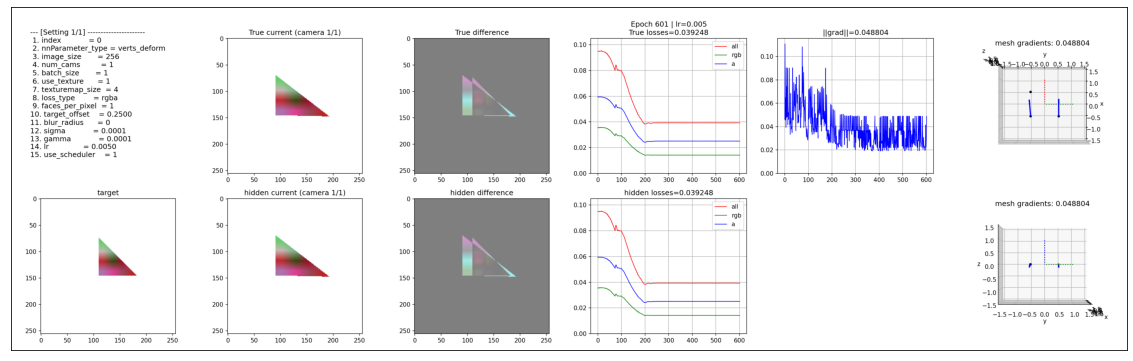

e=601. BREAK
=========== DONE ===========


In [110]:
%matplotlib inline
torch.cuda.empty_cache()
in_dir = './2_data'
#obj_names = ['triangle', 'tetrahedron']
obj_names = [obj_name]
mesh_paths = []
for obj_name in obj_names:
    out_dir = './6b_data/output/{}'.format(obj_name)
    if not os.path.exists(out_dir):
        os.mkdir(out_dir)
    mesh_paths.append(in_dir + '/{}.obj'.format('triangle'))
    print('outputs:', out_dir)

for mesh_idx, mesh_path in enumerate(mesh_paths):
    print('##############################')
    print(mesh_path)
    print('##############################')
    for param_idx, params in enumerate(p_params):
#         if param_idx < 108:
#             continue
        print('Param_idx={}, total count={} ====================================================================================='.format(param_idx, len(p_params)))
        out_dir = './6b_data/output/{}/setting_{}'.format(obj_names[mesh_idx], param_idx)
        if not os.path.exists(out_dir):
            os.mkdir(out_dir)
        gif_path = out_dir + '/plots.gif'
        out_path = out_dir + '/plot.png'
        
        # ====================== #
        # start
        now = datetime.now()
        date_str = '{}{:>02}{:>02}'.format(now.year, now.month, now.day)
        log_path = out_dir + '/log_{}.txt'.format(date_str)
        __output_log(log_path, '========== {} Start ==========================\n'.format(date_str))
        __output_log(log_path, params2string(param_idx, len(p_params), params))
        data_export_path = out_dir + '/data_{}.txt'.format(date_str)
        data_str = 'timestamp;epoch;loss_true;loss_rgb_true;loss_a_true;loss;loss_rgb;loss_a;grad_vec;grad_norm\n'
        __output_log(data_export_path, '========== {} Start ==========================\n'.format(date_str))
        __output_log(data_export_path, data_str)
        print('Log output: {}'.format(log_path))
        

        num_cams = params['num_cams']
        batch_size = params['batch_size']
        loss_type = params['loss_type']
        nnParameter_type = params['nnParameter_type']
        use_texture = params['use_texture']
        image_size = params['image_size']
        mesh_target = gen_mesh(mesh_path, device, params, deform=True)
        mesh = gen_mesh(mesh_path, device, params, deform=False)
        model = Model(device=device, mesh=mesh, mesh_target=mesh_target, nnParameter_type=nnParameter_type, loss_type=loss_type, n_cams=num_cams, batch_size=batch_size, use_texture=use_texture, image_size=image_size)

        

        lr = params['lr']
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.25, patience=3, verbose=True)
        loop = tqdm_notebook(range(1000000000))

        cam_idx = 0
        sigma = params['sigma']
        gamma = params['gamma']
        blur_radius = params['blur_radius']
        faces_per_pixels = params['faces_per_pixel']
        blend_params = BlendParams(sigma=sigma, gamma=gamma)
        raster_settings = RasterizationSettings(
                    image_size=image_size, 
                    blur_radius=blur_radius,
                    faces_per_pixel=faces_per_pixel, 
        )

        images = []
        losses = {'all': [], 'pixel': [], 'silhouette': []}
        losses_true = {'all': [], 'pixel': [], 'silhouette': []}

        grads = []
        latest_states = {}
        for e in loop:
            t0 = time.time()
            export_plots = (e % 10 == 0)
            lr_curr = optimizer.param_groups[0]['lr']

            optimizer.zero_grad()

            loss_dict = {'all': 0.0, 'pixel': 0.0, 'silhouette': 0.0}
            loss_true_dict = {'all': 0.0, 'pixel': 0.0, 'silhouette': 0.0}
            image_dict = {'images': torch.empty(model.n_batch*model.batch_size, image_size, image_size, 4), 
                          'target_images': torch.empty(model.n_batch*model.batch_size, image_size, image_size, 4)}
            image_true_dict = {'images': torch.empty(model.n_batch*model.batch_size, image_size, image_size, 4)}

            for batch_idx in range(model.n_batch):
                img_dict, img_true_dict, l_dict, l_true_dict = model(batch_idx=batch_idx, raster_settings=raster_settings, blend_params=blend_params)
                loss = l_dict['all']
                loss_pixel = l_dict['pixel']
                loss_sil = l_dict['silhouette']
                
                loss_true = l_true_dict['all']
                loss_pixel_true = l_true_dict['pixel']
                loss_sil_true = l_true_dict['silhouette']
                
                loss.backward()
                optimizer.step()

                loss_dict['all'] += loss.data / model.n_batch
                loss_true_dict['all'] += loss_true.data / model.n_batch
                if loss_pixel is not None:
                    loss_dict['pixel'] += loss_pixel / model.n_batch
                    loss_true_dict['pixel'] += loss_pixel_true / model.n_batch
                if loss_sil is not None:
                    loss_dict['silhouette'] += loss_sil / model.n_batch
                    loss_true_dict['silhouette'] += loss_sil_true / model.n_batch

                i0 = batch_idx*model.batch_size
                i1 = i0 + model.batch_size
                image_dict['images'][i0:i1] = img_dict['images']
                image_dict['target_images'][i0:i1] = img_dict['target_images']
                image_true_dict['images'][i0:i1] = img_true_dict['images']

                
            loop.set_description('p[{}/{}] E[{}] lr({}) loss({:.3f})'.format(param_idx+1, len(p_params), e+1, lr_curr, loss_dict['all']))
            losses['all'].append(loss_dict['all'])
            losses_true['all'].append(loss_true_dict['all'])
            if loss_pixel is not None:
                losses['pixel'].append(loss_dict['pixel'])
                losses_true['pixel'].append(loss_true_dict['pixel'])
            else:
                losses['pixel'].append(-1)
                losses_true['pixel'].append(-1)
            if loss_sil is not None:
                losses['silhouette'].append(loss_dict['silhouette'])
                losses_true['silhouette'].append(loss_true_dict['silhouette'])
            else:
                losses['silhouette'].append(-1)
                losses_true['silhouette'].append(-1)

            # =============== #
            # plots
            # =============== 
            grad_norm = None
            grad_value = None
            if nnParameter_type == 'translate':
                grad_value = model.center_offset.grad.detach().cpu().numpy()
                grad_norm = np.linalg.norm(grad_value)
            elif nnParameter_type == 'verts_deform':
                grad_value = model.dverts.grad.detach().cpu().numpy()
                grad_norm = np.linalg.norm(grad_value)
            grads.append(grad_norm)
            print(grad_value)
            print(grad_norm)
            if export_plots:
                if loss_pixel is not None:
                    image_out = image_dict['images'][cam_idx, ..., :3]
                    image_out_true = image_true_dict['images'][cam_idx, ..., :3]
                    image_out_target = image_dict['target_images'][cam_idx, ..., :3]
                else:
                    image_out = image_dict['images'][cam_idx, ..., 3]
                    image_out_true = image_true_dict['images'][cam_idx, ..., 3]
                    image_out_target = image_dict['target_images'][cam_idx, ..., 3]
                image_out = image_out.detach().cpu().numpy()
                image_out_true = image_out_true.cpu().numpy()
                image_out_target = image_out_target.detach().cpu().numpy()

                if e == 0:
                    plot = render_plots(True, True, out_dir, e, param_idx, p_params, cam_idx, model, lr_curr, losses, losses_true, grad_value, grads, image_out_true, image_out, image_out_target)
                    plt.figure(figsize=(20, 10))
                    plt.imshow(plot)
                    plt.xticks([]), plt.yticks([])
                    plt.show()
                else:
                    _ = render_plots(False, True, out_dir, e, param_idx, p_params, cam_idx, model, lr_curr, losses, losses_true, grad_value, grads, image_out_true, image_out, image_out_target)

                
            # =============== #
            # log
            # =============== #
            t1 = time.time()
            mb_alloc = torch.cuda.memory_allocated() * 0.000001
            mb_cached = torch.cuda.memory_cached() * 0.000001
            now = datetime.now()
            hour = str(now.hour)
            minute = str(now.minute)
            second = str(now.second)
            now_str = '{:>02}:{:>02}:{:>02}'.format(hour, minute, second)
            out_str = '{} | {:04} | {:.2f}s | lr={:.8f} | loss_all_true={:.6f}, loss_all={:.6f} | GPU_allocated({:,.2f}Mb) | GPU_cached({:,.2f}Mb)\n'.format(now_str, e+1, t1-t0, lr_curr, loss_true_dict['all'], loss_dict['all'], mb_alloc, mb_cached)
            __output_log(log_path, out_str)

            # cf) data_str = 'timestamp epoch loss loss_rgb loss_a grad_vec grad_norm\n'
            grad_value_str = np.array_repr(grad_value).replace('\n', '')
            data_str = '{};{};{};{};{};{};{};{};{};{}\n'.format(now_str, e, losses_true['all'][-1], losses_true['pixel'][-1], losses_true['silhouette'][-1], losses['all'][-1], losses['pixel'][-1], losses['silhouette'][-1], grad_value_str, grads[-1])
            __output_log(data_export_path, data_str)

#             scheduler.step(loss)
            if lr_curr < 1e-10:
                print('lr={}. BREAK'.format(lr_curr))
                plot = render_plots(True, True, out_dir, e, param_idx, p_params, cam_idx, model, lr_curr, losses, losses_true, grad_value, grads, image_out_true, image_out, image_out_target)
                plt.figure(figsize=(20, 10))
                plt.imshow(plot)
                plt.xticks([]), plt.yticks([])
                plt.show()
                break

            if e > 600:
                plot = render_plots(True, True, out_dir, e, param_idx, p_params, cam_idx, model, lr_curr, losses, losses_true, grad_value, grads, image_out_true, image_out, image_out_target)
                plt.figure(figsize=(20, 10))
                plt.imshow(plot)
                plt.xticks([]), plt.yticks([])
                plt.show()
                print('e={}. BREAK'.format(e))
                break
print('=========== DONE ===========')

In [ ]:
images[0].save(gif_path, save_all=True, append_images=images[1:], optimize=False, duration=100, loop=0)
print('gif saved:', gif_path)